In [1]:
import psycopg2
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 처리

In [2]:
#DB 불러오기
conn= psycopg2.connect(dbname="child", user="postgres", password="qpwoeiruty12")
cur= conn.cursor()

In [3]:
def make_df(conn,cur,name):
    contents= cur.execute(f"SELECT * FROM {name}")
    col_list=['id', 'afos_fid', 'afos_id', 'bjd_cd', 'spot_cd', 'sido_sgg_nm', 'spot_nm', 'occrrnc_cnt', 'caslt_cnt', 'dth_dnv_cnt', 'se_dnv_cnt','sl_dnv_cnt', 'wnd_dnv_cnt', 'lo_crd', 'la_crd']
    
    df= pd.DataFrame(cur.fetchall(), columns=col_list)
    df.set_index('id', inplace=True)
    return df


child= make_df(conn,cur,'child')
schoolzone= make_df(conn,cur,'schoolzone')
#두 데이터를 병합하도록 합시다

data= pd.concat([child,schoolzone])
data.reset_index(inplace=True, drop= True)

In [4]:
data.head()

,afos_fid,afos_id,bjd_cd,spot_cd,sido_sgg_nm,spot_nm,occrrnc_cnt,caslt_cnt,dth_dnv_cnt,se_dnv_cnt,sl_dnv_cnt,wnd_dnv_cnt,lo_crd,la_crd
0,138468,2013097,1117013100,11170001,서울특별시 용산구1,서울특별시 용산구 한남동(순천향병원 부근),3,3,0,0,2,1,127.005586,37.533295
1,144026,2013097,1120010700,11200001,서울특별시 성동구1,서울특별시 성동구 행당동(무학여고앞 부근),4,5,0,0,5,0,127.032724,37.558635
2,144027,2013097,1121510300,11215001,서울특별시 광진구1,서울특별시 광진구 구의동(슬기유치원앞 부근),3,3,0,2,1,0,127.093095,37.552232
3,140161,2013097,1121510400,11215002,서울특별시 광진구2,서울특별시 광진구 광장동(광장사거리 부근),5,5,0,1,3,1,127.103648,37.544331
4,138521,2013097,1126010300,11260001,서울특별시 중랑구1,서울특별시 중랑구 중화동(태능시장 부근),3,3,0,0,2,1,127.076933,37.598100


In [5]:
kmeans_data=data[['lo_crd','la_crd']]

In [6]:
#특성공학
def engineering(df):
    #중복되는 특성을 제거해줍니다.
    df.drop(['sido_sgg_nm','spot_nm', 'lo_crd', 'la_crd'], axis=1, inplace=True)
    
    #불필요한 특성을 제거해줍니다.
    df.drop(['afos_fid'], axis=1, inplace=True)
    
    #target 특성을 제작합니다.
    high_condition = df['occrrnc_cnt'] >= 5
    low_condition = df['occrrnc_cnt'] <= 2
    base = [1] * len(df) 
    df['target']= base
    df.loc[df[high_condition].index,'target'] = 2
    df.loc[df[low_condition].index,'target'] = 0
    df.drop('occrrnc_cnt', axis=1, inplace=True)

engineering(data)

In [7]:
data.head()

,afos_id,bjd_cd,spot_cd,caslt_cnt,dth_dnv_cnt,se_dnv_cnt,sl_dnv_cnt,wnd_dnv_cnt,target
0,2013097,1117013100,11170001,3,0,0,2,1,1
1,2013097,1120010700,11200001,5,0,0,5,0,1
2,2013097,1121510300,11215001,3,0,2,1,0,1
3,2013097,1121510400,11215002,5,0,1,3,1,2
4,2013097,1126010300,11260001,3,0,0,2,1,1


사고 발생 횟수가 3회인 다발지역이 가장 많다. 따라서 0~2를 위험도 낮은 지역으로 잡으면 될 것 같다.
3회 이상인 부분은 위험도 높은 지역으로 생각하면 될 것 같다.

<AxesSubplot:ylabel='Frequency'>

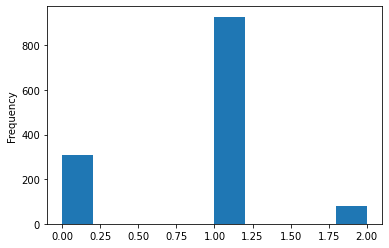

In [8]:
data['target'].plot.hist()

# 모델링작업

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [10]:
#데이터셋 분리
train, test = train_test_split(data, train_size=0.8, test_size= 0.2, random_state=42)

target='target'

y_train = train[target]
X_train = train.drop(target, axis= 1)

y_test = test[target]
X_test = test.drop(target, axis= 1)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1052, 8) (1052,)
(263, 8) (263,)


In [11]:
rf= RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42, class_weight="balanced")

dists={
    "n_estimators": [1,5,10,30,50,100],
    "max_depth": [10, 15, 20, 25, 30]
}

rscv = GridSearchCV(estimator=rf, param_grid=dists,
                         scoring="accuracy",
                         n_jobs=-1,
                         verbose=1,
                         cv= 3)
rscv.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\dgfs5\anaconda3\envs\project3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25, 30],
                         'n_estimators': [1, 5, 10, 30, 50, 100]},
             scoring='accuracy', verbose=1)

In [12]:
model = rscv.best_estimator_

print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       250
           1       0.99      0.99      0.99       736
           2       0.85      0.97      0.91        66

    accuracy                           0.98      1052
   macro avg       0.95      0.97      0.96      1052
weighted avg       0.98      0.98      0.98      1052



In [13]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95        58
           1       0.96      0.97      0.96       193
           2       0.64      0.75      0.69        12

    accuracy                           0.95       263
   macro avg       0.86      0.88      0.87       263
weighted avg       0.95      0.95      0.95       263



In [31]:
model.predict(X_test)

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2,
       1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
      dtype=int64)

In [ ]:
pd.DataFrame

In [14]:
X_train.head()

,afos_id,bjd_cd,spot_cd,caslt_cnt,dth_dnv_cnt,se_dnv_cnt,sl_dnv_cnt,wnd_dnv_cnt
209,2014110,1130510200,11305003,3,0,0,3,0
312,2014110,4514012200,45140001,4,0,2,2,0
140,2013097,4425031500,44250001,3,0,1,2,0
905,2020016,4311210600,43112001,3,0,1,2,0
783,2019035,2623010900,26230001,5,0,2,2,1


In [15]:
data.head()

,afos_id,bjd_cd,spot_cd,caslt_cnt,dth_dnv_cnt,se_dnv_cnt,sl_dnv_cnt,wnd_dnv_cnt,target
0,2013097,1117013100,11170001,3,0,0,2,1,1
1,2013097,1120010700,11200001,5,0,0,5,0,1
2,2013097,1121510300,11215001,3,0,2,1,0,1
3,2013097,1121510400,11215002,5,0,1,3,1,2
4,2013097,1126010300,11260001,3,0,0,2,1,1


C:\Users\dgfs5\anaconda3\envs\project3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


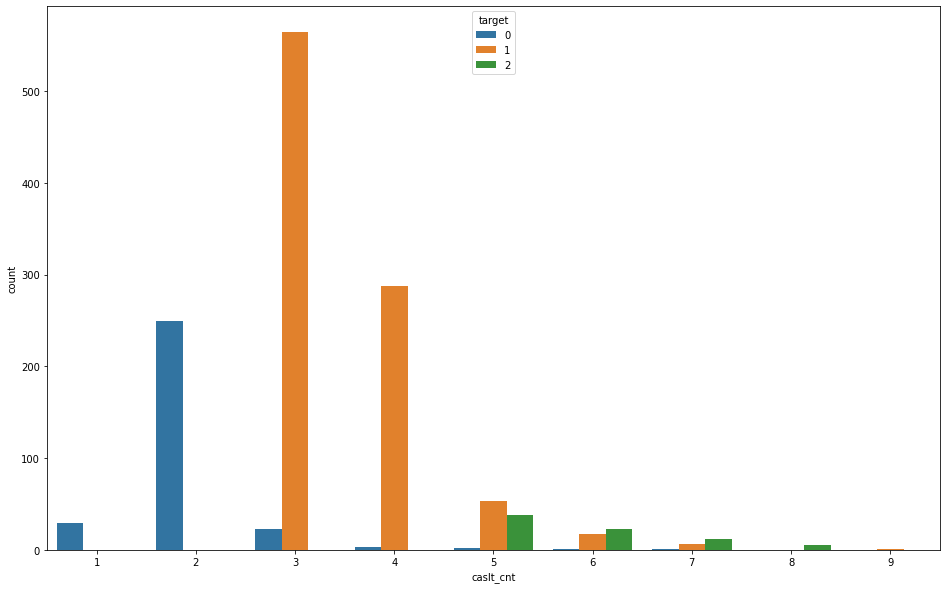

In [16]:
#데이터 누수?

plt.figure(figsize=(16, 10))
sns.countplot('caslt_cnt', hue= 'target',data=data)
plt.show()

C:\Users\dgfs5\anaconda3\envs\project3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

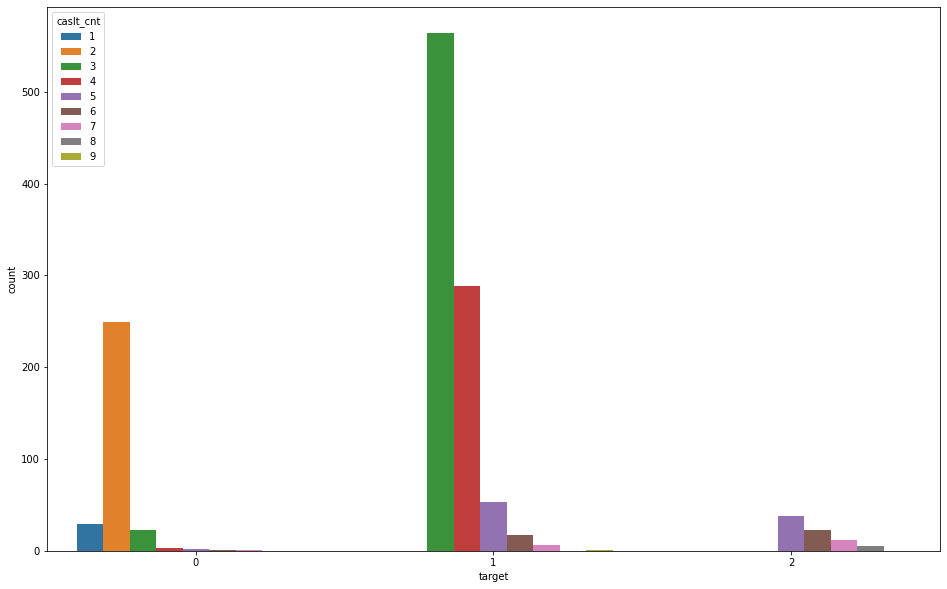

In [17]:
plt.figure(figsize=(16, 10))
sns.countplot('target', hue= 'caslt_cnt',data=data)

<AxesSubplot:>

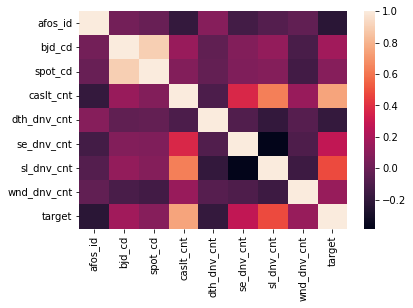

In [18]:
sns.heatmap(data=data.corr())

In [19]:
kmeans_data

,lo_crd,la_crd
0,127.005586,37.533295
1,127.032724,37.558635
2,127.093095,37.552232
3,127.103648,37.544331
4,127.076933,37.598100
...,...,...
1310,129.229277,35.847847
1311,128.692913,36.560284
1312,127.909665,35.688295
1313,126.401987,33.480252


In [20]:
from sklearn.cluster import KMeans

<AxesSubplot:xlabel='lo_crd', ylabel='la_crd'>

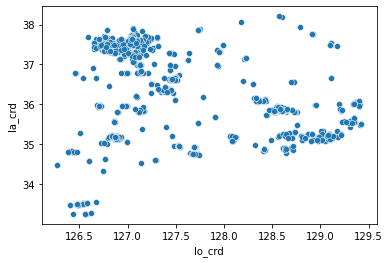

In [21]:
sns.scatterplot(x=kmeans_data['lo_crd'], y=kmeans_data['la_crd'])

In [22]:
sum_of_distance=[]
for i in range(1,20):
    kmeans= KMeans(n_clusters=i)
    kmeans.fit(kmeans_data)
    sum_of_distance.append(kmeans.inertia_) 

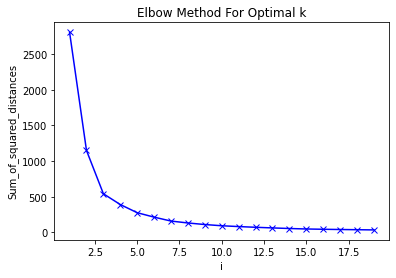

In [23]:
plt.plot(range(1,20,1), sum_of_distance, 'bx-')
plt.xlabel('i')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [38]:
final= KMeans(n_clusters=5)
last= final.fit(kmeans_data)
label= final.labels_

cluster_data= kmeans_data.copy()
cluster_data['label']= label

cluster_data

,lo_crd,la_crd,label
0,127.005586,37.533295,0
1,127.032724,37.558635,0
2,127.093095,37.552232,0
3,127.103648,37.544331,0
4,127.076933,37.598100,0
...,...,...,...
1310,129.229277,35.847847,4
1311,128.692913,36.560284,4
1312,127.909665,35.688295,4
1313,126.401987,33.480252,3


In [25]:
cluster_data['label'].value_counts()

1    541
0    341
2    203
3    169
4     61
Name: label, dtype: int64

<AxesSubplot:xlabel='lo_crd', ylabel='la_crd'>

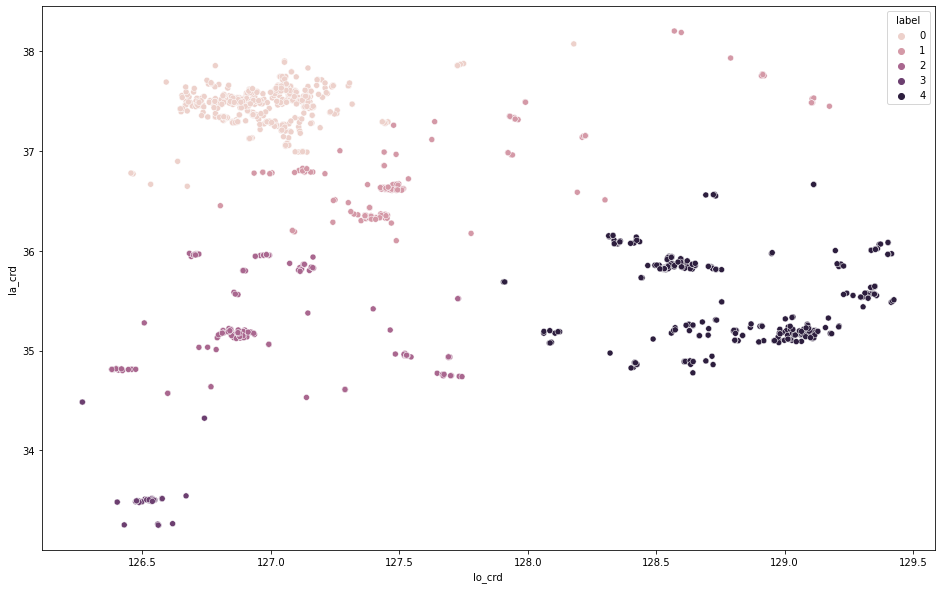

In [39]:
plt.figure(figsize=(16, 10))
sns.scatterplot(x=kmeans_data['lo_crd'], y=kmeans_data['la_crd'], hue= cluster_data['label'])

In [27]:
pd.DataFrame([[128.6374338,88746268]])

,0,1
0,128.637434,88746268


In [41]:
final.predict([[126.714628,33.31111895]])[0]

C:\Users\dgfs5\anaconda3\envs\project3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


3

In [29]:
cluster_data['label'].value_counts()

1    541
0    341
2    203
3    169
4     61
Name: label, dtype: int64

In [40]:


#cluster 모델 피클링
#import pickle

#with open('./model.pkl', 'wb') as pickle_file:
#    pickle.dump(final, pickle_file)